In [4]:
#Importing the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [6]:
#Importing the dataset
df = pd.read_csv('BTC-USD.csv',index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-06-26,21496.494141,21783.724609,21016.269531,21027.294922,21027.294922,18027170497
2022-06-27,21028.238281,21478.089844,20620.199219,20735.478516,20735.478516,20965695707
2022-06-28,20731.544922,21164.423828,20228.812500,20280.634766,20280.634766,21381535161


In [7]:
#Get the number of rows and columns in the data set
df.shape
df.iloc[df.values==-np.inf]
df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

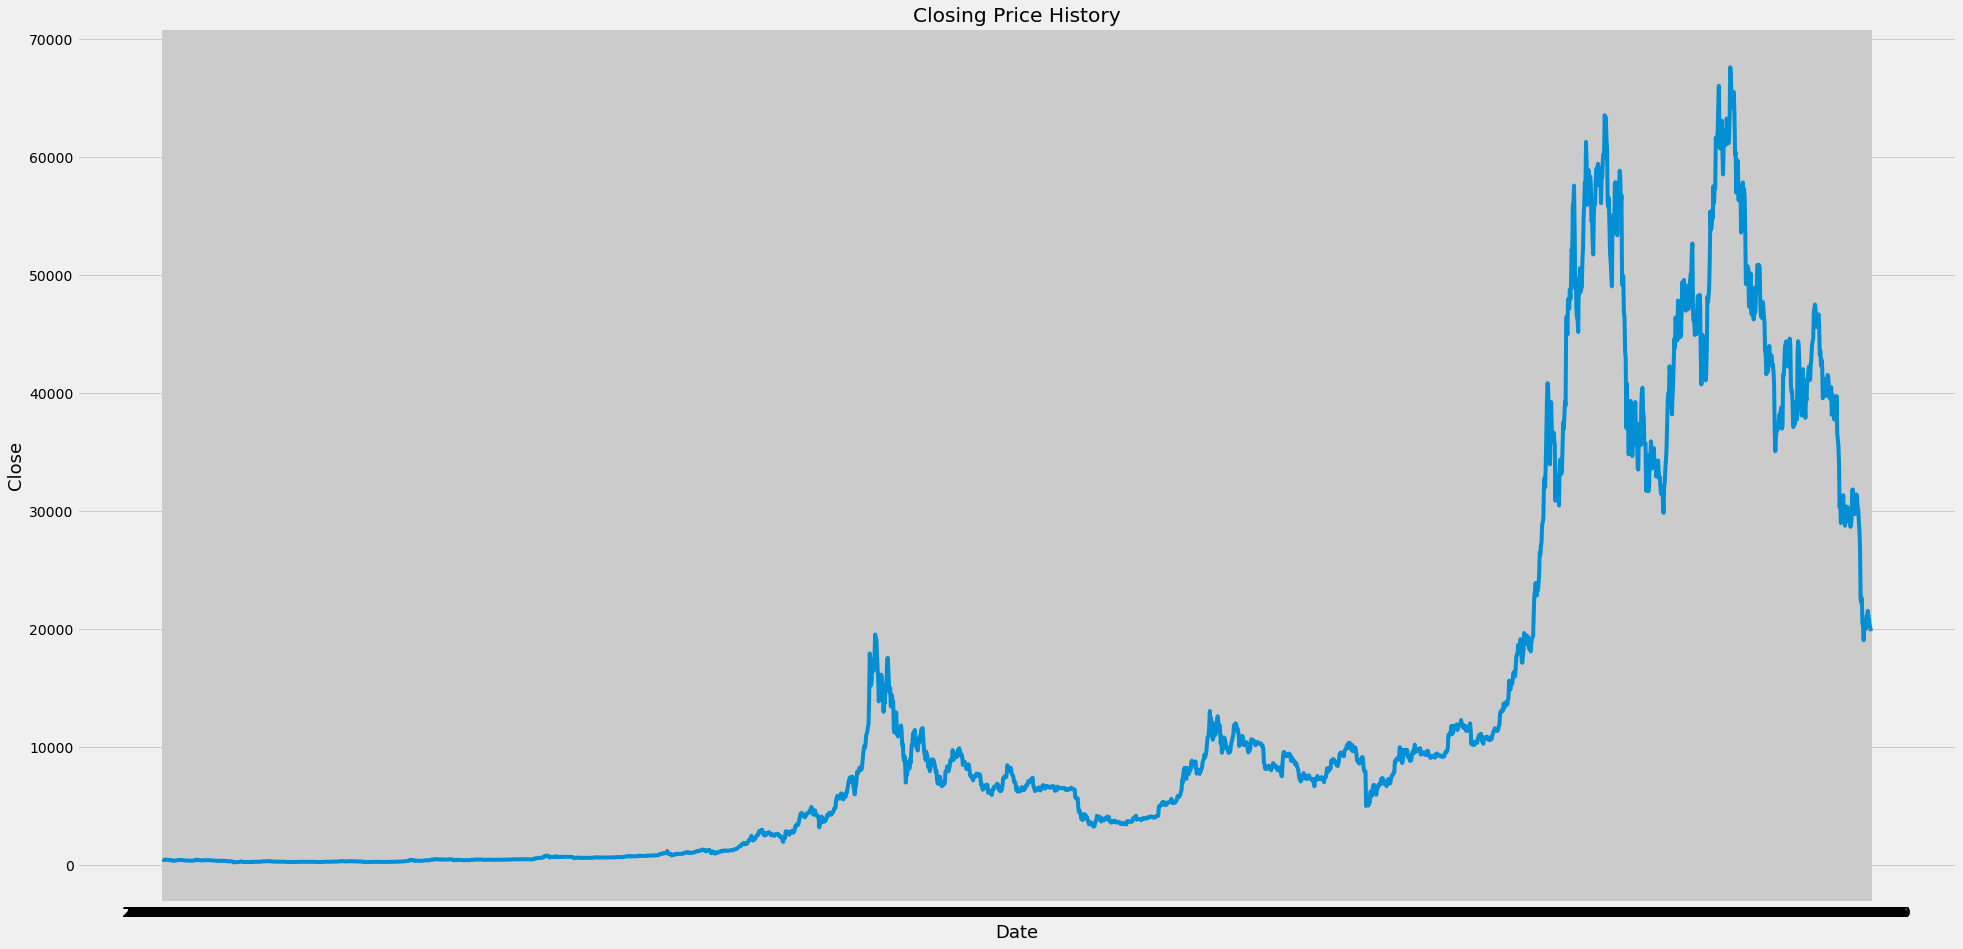

In [8]:
#Visualizing the closing price history
plt.figure(figsize=(30,15))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.show()

In [9]:
  #Create a new dataframe with only Close column
  data = df.filter(['Close'])
  #Convert the dataframe to a numpy array
  dataset = data.values
  #Get number of rows to train the model
  training_data_len = math.ceil(len(dataset)*.8)
  training_data_len

2276

In [10]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data
scaled_data.shape

(2844, 1)

In [11]:
#Create training data set
#Cretae the scaled training data set
train_data = scaled_data[0:training_data_len, :]
#Split the data into X_train and Y_train data sets
x_train = []
y_train = []

for i in range(6, len(train_data)):
  x_train.append(train_data[i-6:i, 0])
  y_train.append(train_data[i, 0])
  if i<= 7:
    print(x_train)
    print(y_train)
    print()


[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473])]
[0.003823903590853519]

[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473]), array([0.00365546, 0.00321557, 0.00342492, 0.0032753 , 0.00332473,
       0.0038239 ])]
[0.003823903590853519, 0.0036371364725248405]



In [12]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2270, 6, 1)

In [14]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2270/2270 [==============================] - 12s 4ms/step - loss: 1.9882e-04


In [17]:
#Create the testing data set
#Create a new array containing scaled values from index 
test_data = scaled_data[training_data_len - 6: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(6, len(test_data)):
  x_test.append(test_data[i-6:i, 0])

In [18]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [19]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [20]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

18/18 [==============================] - 1s 3ms/step


In [21]:
mse=0
maxii = 0
count = 0
for i in range(len(predictions)):
  mse+=(y_test[i,0]-predictions[i,0])**2
  maxii = max(maxii,(y_test[i,0]-predictions[i,0])**2)
  if (y_test[i,0]-predictions[i,0]) > 1000:
    count += 1
m = mse/len(predictions)
m

7031492.294024741

In [22]:
count


223

In [64]:
#Get the mean squared error (MSE)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, predictions)

39590479.13126701

In [56]:
#Get R^2 Score
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.918024321279685

In [57]:
#Get Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions)

2477.951756463248

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


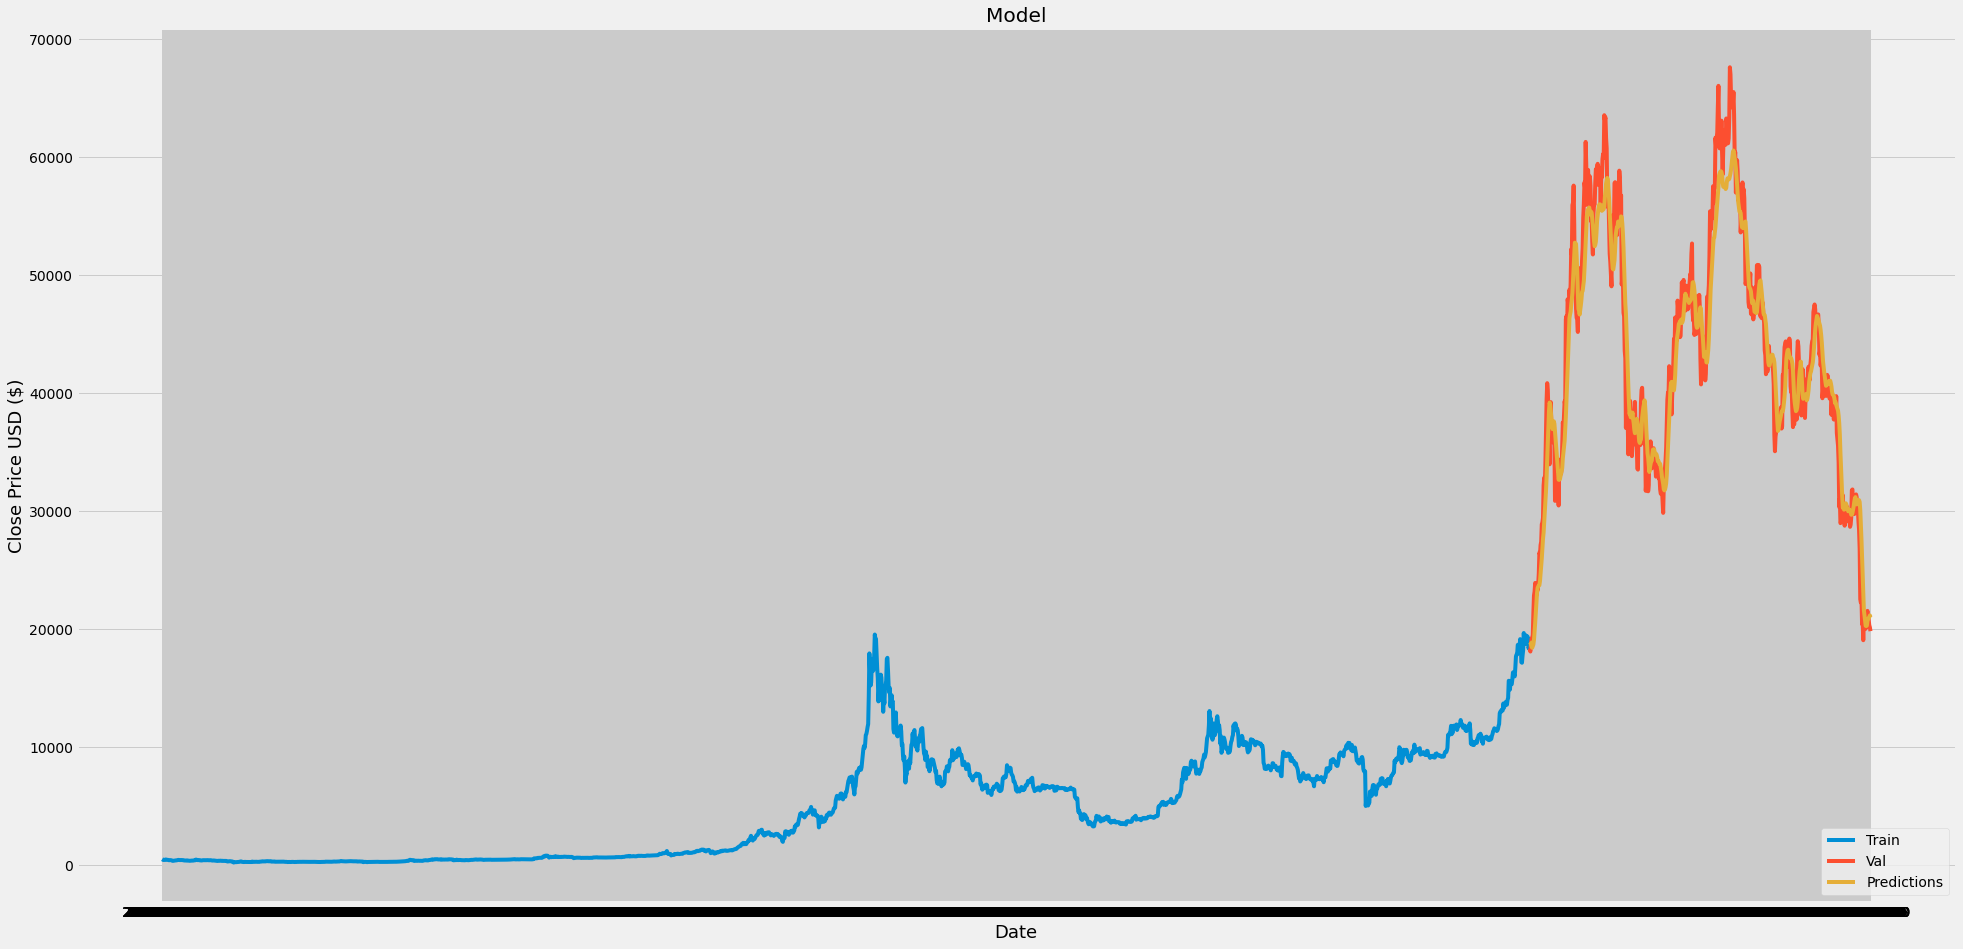

In [58]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(30,15))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
predictions
plt.show()